In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import auc,accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids,TomekLinks,NeighbourhoodCleaningRule,NearMiss

def down_sampling(X,y,down_sampling_type,info):
    '''refer : https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8'''
    
    #random under sampling
    if down_sampling_type == 'random':
        sampler = RandomUnderSampler(sampling_strategy = 15/85,random_state=0)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After random down sampling {}'.format(Counter(y_ds)))
        return X_ds,y_ds
    
    #nearmiss under sampling
    if down_sampling_type == 'nearmiss':
        sampler = NearMiss(sampling_strategy = 15/85,random_state=0)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After nearmiss down sampling {}'.format(Counter(y_ds)))        
    return X_ds,y_ds

#------------------------------------------------------------------------
    
def up_sampling(X,y,info):
    
    #up sampling
    sm = SMOTE(sampling_strategy = 30/70,random_state=0 )
    X_us, y_us = sm.fit_sample(X, y)
    if info:
        print('After SMOTE up sampling {}'.format(Counter(y_us)))
    return X_us,y_us

#------------------------------------------------------------------------
    
def re_sampling(X,y,info,sampling_type,down_sampling_type):
    
    if sampling_type=='none':
        if info:
            print('split as in original data {}'.format(Counter(y)))
        return X,y

    if sampling_type=='down_sampling':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        return X_ds,y_ds
    
    if sampling_type=='up_sampling':
        X_us,y_us = up_sampling(X,y,info=info)
        return X_us,y_us
    
    if sampling_type=='hybrid':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        X_hs,y_hs = up_sampling(X_ds,y_ds,info=info)
        return X_hs,y_hs

#----------------------------------------------------------------------------------

def train_test_resampled_split(X,y,info,sampling_type,down_sampling_type,test_size):  
    
    if info:
        print('Before sampling {}'.format(Counter(y)))
    X_rs,y_rs = re_sampling(X,y,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    
    
    X_train,X_test,y_train,y_test = train_test_split(X_rs,y_rs,test_size=test_size,random_state=0,stratify=y_rs)
    
    print('-'*50)
    
    return X_train,X_test,y_train,y_test

#----------------------------------------------------------------------------------

def cutoff_point(model,X,y,info,test_size,sampling_type,down_sampling_type,cv_search):

    X_train,X_test,y_train,y_test = train_test_resampled_split(X=X,y=y,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    if cv_search != True:
        model[1].fit(X_train, y_train)

    prd = model[1].predict(X_test)
    proba = model[1].predict_proba(X_test)
    
    y_pred_df = pd.DataFrame(proba)
    y_pred_1 = y_pred_df.iloc[:,1]
    y_test_df = pd.DataFrame(y_test)

    y_pred_1.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
    y_pred_final= y_pred_final.rename(columns={ 0:'readmitted',1 : 'readmitted_probability'})
    y_pred_final['predicted'] = y_pred_final.readmitted_probability.map( lambda x: 1 if x > 0.5 else 0)
   

    numbers = [float(x)/100 for x in range(100)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.readmitted_probability.map( lambda x: 1 if x > i else 0)
    y_pred_final.head()

    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity','var_ssa','recall','precision','var_pra','Area Under Curve'])
    from sklearn.metrics import confusion_matrix
    
    for i in numbers:
        cm1 = confusion_matrix( y_pred_final.readmitted, y_pred_final[i] )
        total1=sum(sum(cm1))
        
        tp = cm1[0,0]
        tn = cm1[1,1]
        fp = cm1[1,0]
        fn = cm1[0,1]
        
        accuracy = (tp+tn)/total1
        
        sensi = tp/(tp+fn)
        speci = tn/(tn+fp)
        
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        
        var_ssa = np.std([accuracy,sensi,speci])
        var_pra = np.std([accuracy,recall,precision])
        
        fpr, tpr, thresholds = roc_curve(y_pred_final.readmitted, y_pred_final[i])
        auc = metrics.auc(fpr, tpr)
        
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci,var_ssa,recall,precision,var_pra,auc]

    print('-'*50)
    print('Finding Optimal Cutoff Point based on accuracy, recall, precision')
    cutoff_df.plot.line(x='prob', y=['accuracy','recall','precision'])
    plt.show()
    optimum_pra = cutoff_df.iloc[cutoff_df['var_pra'].argmin()]
    print('Optimum cutoff probability is {0:.2f}'.format(optimum_pra[0]))
    
    optimum_accuracy = accuracy_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_precision = precision_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_recall = recall_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_roc_auc = roc_auc_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    
    print("Accuracy is {0:.2f}".format(optimum_accuracy))
    print("Precision is {0:.2f}".format(optimum_precision))
    print("Recall is {0:.2f}".format(optimum_recall))
    print("ROC_AUC Score is {0:.2f}".format(optimum_roc_auc))
    
    result_for_optimized.loc[model[0]+'_OC'] = [optimum_accuracy,optimum_precision,optimum_recall,optimum_roc_auc]
    
    print("\nClassification report\n",classification_report(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    print("confusion matrix \n\n", confusion_matrix(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    
    return cutoff_df

#----------------------------------------------------------------------------------

def plot_roc_curve(y_true,proba):
    fpr, tpr, threshold = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#----------------------------------------------------------------------------------
    
def model_check(model,X,y,sampling_type,down_sampling_type,test_size=0.15,cv_search=False,info=False):
    
    print(model[0])
    print('-'*50)
    
    if cv_search :
        
        print('Data set Before resampling {}'.format(Counter(y)) if info else '')
        
        X_train,X_test,y_train,y_test, = train_test_resampled_split(X,y,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type,info=info)
        
        print('Train set After resampling {}'.format(Counter(y_train)))
        print('Test set After resampling {}'.format(Counter(y_test)))
            
        model[1].fit(X_train, y_train)
        prd = model[1].predict(X_test)
        proba = model[1].predict_proba(X_test)[:,1]

        accuracy = accuracy_score(y_test, prd)
        precision = precision_score(y_test, prd)
        recall = recall_score(y_test, prd)
        roc_auc = roc_auc_score(y_test,proba)

        print("Accuracy is {0:.2f}".format(accuracy))
        print("Precision is {0:.2f}".format(precision))
        print("Recall is {0:.2f}".format(recall))
        print("ROC_AUC Score is {0:.2f}".format(roc_auc))
        plot_roc_curve(y_test,proba)
        print("\nClassification report\n",classification_report(y_test, prd))
        print("confusion matrix \n\n", confusion_matrix(y_test,prd)) 
        print('-'*50)
        print('best_parameters')
        print(model[1].best_params_)
        
        result.loc[model[0]] = [accuracy,precision,recall,roc_auc]

        
    else : 
    
        kf = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
        i=1
        cv_results=[]
        cv_df = pd.DataFrame( columns = ['kfold','accuracy','recall','precision','ROC_AUC'])
        for train_index,test_index in kf.split(X,y):
            print('{} of KFold {}'.format(i,kf.n_splits))

            xtr,xte = X.loc[train_index],X.loc[test_index]
            ytr,yte = y.loc[train_index],y.loc[test_index]

            X_tr_rs,y_tr_rs = re_sampling(xtr,ytr,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            X_te_rs,y_te_rs = re_sampling(xte,yte,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            model[1].fit(X_tr_rs, y_tr_rs)
            y_pred = model[1].predict(X_te_rs)
            y_proba = model[1].predict_proba(X_te_rs)[:,1]

            accuracy = accuracy_score(y_te_rs, y_pred)
            precision = precision_score(y_te_rs, y_pred)
            recall = recall_score(y_te_rs, y_pred)
            roc_auc = roc_auc_score(y_te_rs,y_proba)
            
            cv_df.loc[i] =[ i ,accuracy,recall,precision,roc_auc]
            '''print("\nAccuracy is {0:.2f}".format(accuracy))
            print("Precision is {0:.2f}".format(precision))
            print("Recall is {0:.2f}".format(recall))
            print("ROC_AUC Score is {0:.2f}".format(roc_auc))

            plot_roc_curve(y_te_rs,y_proba)

            print("\nClassification report\n",classification_report(y_te_rs, y_pred))
            print("confusion matrix \n\n", confusion_matrix(y_te_rs,y_pred))
            print('-'*50)'''

            i+=1    

        print('\n\n',cv_df)
        print('\nAverage accuracy after k-fold = {}'.format(np.mean(cv_df['accuracy'])))
        print('Average recall after k-fold = {}'.format(np.mean(cv_df['recall'])))
        print('Average precision after k-fold = {}'.format(np.mean(cv_df['precision'])))
        print('Average ROC_AUC after k-fold = {}'.format(np.mean(cv_df['ROC_AUC'])))
    
        result.loc[model[0]] = [np.mean(cv_df['accuracy']),np.mean(cv_df['precision']),np.mean(cv_df['recall']),np.mean(cv_df['ROC_AUC'])]
    
    print('-'*50)
    print('\n')
    cutoff_df = cutoff_point(model,X,y,cv_search=cv_search,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

    return 

result = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])
result_for_optimized = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])

In [9]:
data = pd.read_csv('final_data.csv')
X = data.drop('readmitted',axis=1)
y = data['readmitted']

Decision Tree Classifier
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.734630  0.554682   0.557971  0.683205
2     2.0  0.759969  0.613621   0.597196  0.718146
3     3.0  0.754610  0.625245   0.585067  0.717586
4     4.0  0.768144  0.619359   0.612153  0.725622
5     5.0  0.749117  0.588620   0.580645  0.703248
6     6.0  0.752112  0.584152   0.587228  0.704113
7     7.0  0.747397  0.573019   0.579854  0.697564
8     8.0  0.751915  0.584152   0.586842  0.703856
9     9.0  0.752308  0.580878   0.588196  0.703259
10   10.0  0.743665  0.567780   0.573413  0.693402

Average accuracy after k-fold = 0.7513867000735689
Average recall after k-fold = 0.5891508547046984
Average precision after k-fold = 0.5848565452598693
Average ROC_AUC after k-fold = 0.705000174664055
-----------------

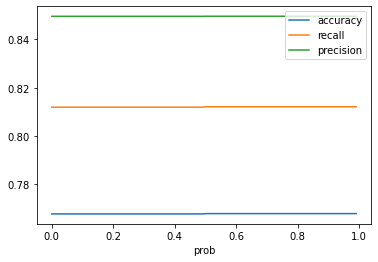

Optimum cutoff probability is 0.50
Accuracy is 0.77
Precision is 0.60
Recall is 0.66
ROC_AUC Score is 0.74

Classification report
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      5349
           1       0.60      0.66      0.63      2293

    accuracy                           0.77      7642
   macro avg       0.73      0.74      0.73      7642
weighted avg       0.78      0.77      0.77      7642

confusion matrix 

 [[4344 1005]
 [ 769 1524]]


In [10]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
model = ['Decision Tree Classifier',dtc]
model_check(model,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',cv_search=False,info=False)

Decision Tree Classifier with Randomsearch CV
--------------------------------------------------

--------------------------------------------------
Train set After resampling Counter({0: 28528, 1: 12225})
Test set After resampling Counter({0: 7132, 1: 3057})
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

Accuracy is 0.78
Precision is 0.63
Recall is 0.66
ROC_AUC Score is 0.74


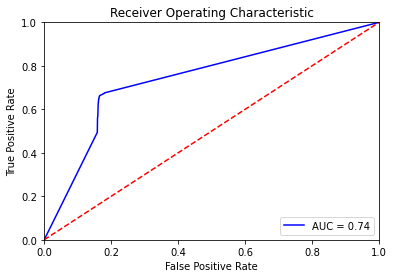


Classification report
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      7132
           1       0.63      0.66      0.65      3057

    accuracy                           0.78     10189
   macro avg       0.74      0.75      0.74     10189
weighted avg       0.79      0.78      0.78     10189

confusion matrix 

 [[5948 1184]
 [1030 2027]]
--------------------------------------------------
best_parameters
{'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 35, 'criterion': 'entropy'}
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------
Finding Optimal Cutoff Point based on accuracy, recall, precision


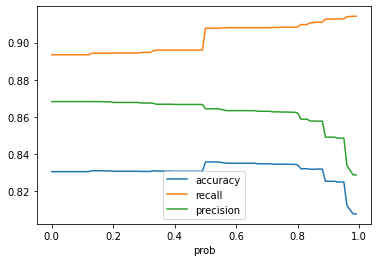

Optimum cutoff probability is 0.00
Accuracy is 0.83
Precision is 0.73
Recall is 0.68
ROC_AUC Score is 0.79

Classification report
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      7132
           1       0.73      0.68      0.71      3057

    accuracy                           0.83     10189
   macro avg       0.80      0.79      0.79     10189
weighted avg       0.83      0.83      0.83     10189

confusion matrix 

 [[6372  760]
 [ 967 2090]]


In [11]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

params = {'max_depth':range(1,40),
             'min_samples_leaf':range(1,20),
             'min_samples_split':range(1,40),
             'criterion':['entropy','gini']}

#hyperparameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, criterion=criterion)

dtc_rcv = ['Decision Tree Classifier with Randomsearch CV',RandomizedSearchCV(dtc, params, random_state=1, n_iter=1000, cv=10, verbose=1, n_jobs=-1,scoring = "recall")]
model_check(dtc_rcv,X,y,test_size=0.20,sampling_type='hybrid',down_sampling_type='nearmiss',cv_search=True,info=False)

In [12]:
X_rs,y_rs = re_sampling(X,y,sampling_type='hybrid',down_sampling_type='nearmiss',info=False)

In [13]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=35, min_samples_leaf=1, min_samples_split=3, random_state=0)

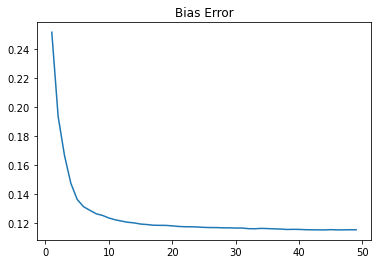

best n_estimator based on bias error =  44


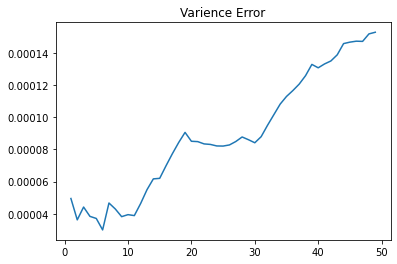

best n_estimator based on variance error =  6


In [14]:
from sklearn.ensemble import AdaBoostClassifier

Ada_dtc_bias=[]
Ada_dtc_var =[]
for val in np.arange(1,50):
    Ada_dtc=AdaBoostClassifier(base_estimator=dtc,n_estimators=val,random_state=0)
    kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(Ada_dtc, X_rs, y_rs,cv=kfold, scoring='roc_auc')
    Ada_dtc_bias.append(1-np.mean(cv_results))
    Ada_dtc_var.append(np.var(cv_results,ddof=1))

x_axis=np.arange(1,50)
plt.plot(x_axis,Ada_dtc_bias)
plt.title('Bias Error')
plt.show()
print('best n_estimator based on bias error = ',(np.argmin(Ada_dtc_bias)+1))
plt.plot(x_axis,Ada_dtc_var)
plt.title('Varience Error')
plt.show()
print('best n_estimator based on variance error = ',(np.argmin(Ada_dtc_var)+1))

In [15]:
Ada_dtc_result = pd.DataFrame()
Ada_dtc_result['N-Estimators'] = np.arange(1,50)
Ada_dtc_result['Variance Error'] = Ada_dtc_var
Ada_dtc_result['Bias Error'] = Ada_dtc_bias
Ada_dtc_result.sort_values('Bias Error').head()

,N-Estimators,Variance Error,Bias Error
43,44,0.000146,0.115222
45,46,0.000147,0.115241
42,43,0.000139,0.115244
46,47,0.000147,0.115262
41,42,0.000135,0.115292


In [16]:
best_boost_est = int(Ada_dtc_result.sort_values('Bias Error').head(1)['N-Estimators'].values)
best_boost_est

44

In [20]:
boosted_DT=['boosted_DT',AdaBoostClassifier(base_estimator=dtc,n_estimators=best_boost_est,random_state=0)]

boosted_DT
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.810450  0.549443   0.751792  0.825088
2     2.0  0.817128  0.556647   0.769928  0.837975
3     3.0  0.815614  0.576848   0.750638  0.830626
4     4.0  0.819341  0.586658   0.756324  0.852122
5     5.0  0.814437  0.547417   0.767186  0.837197
6     6.0  0.806325  0.538965   0.744796  0.815397
7     7.0  0.812218  0.550753   0.756976  0.824371
8     8.0  0.824592  0.580223   0.778559  0.852599
9     9.0  0.819289  0.564506   0.771710  0.836384
10   10.0  0.823610  0.566470   0.785649  0.841538

Average accuracy after k-fold = 0.8163004175323355
Average recall after k-fold = 0.5617929375021147
Average precision after k-fold = 0.7633558093869971
Average ROC_AUC after k-fold = 0.8353295993754093
------------------------------

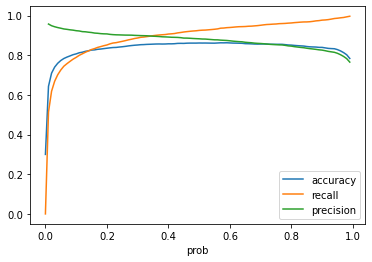

Optimum cutoff probability is 0.34
Accuracy is 0.86
Precision is 0.76
Recall is 0.76
ROC_AUC Score is 0.83

Classification report
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      5349
           1       0.76      0.76      0.76      2293

    accuracy                           0.86      7642
   macro avg       0.83      0.83      0.83      7642
weighted avg       0.86      0.86      0.86      7642

confusion matrix 

 [[4792  557]
 [ 550 1743]]


In [21]:
model_check(boosted_DT,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)